In [152]:
import pandas as pd
import numpy as np
from scipy import integrate
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error, median_absolute_error
from scipy.integrate import odeint
from scipy.optimize import differential_evolution, minimize
import matplotlib.pyplot as plt

In [153]:
import PDEparams as pde

## Data from World Health Organization
#### Only laboratory-confirmed, exclude clinically diagnose

In [154]:
data = pd.read_csv('CoV2019.csv')
china = data["China"][:27]#data["China"][:27]
days = data["Days"][:27]
total = data["Total"][:27]
deaths_china = data["Death China"][:27]
other = data["Other"]
china_total = data["China"]
days_total = data["Days"]
deaths_china_total = data["Death China"]
deaths_outside_total = data["Death Outside"]

### Ploting raw data

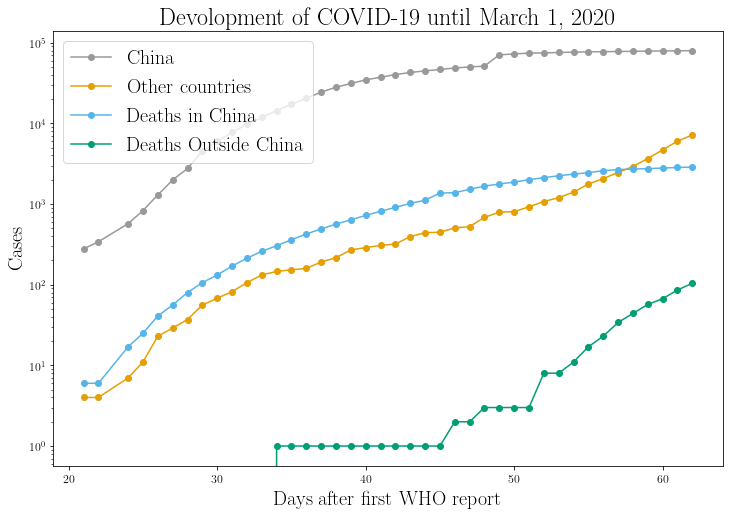

In [155]:
plt.figure(figsize=(12, 8))
plt.title("Devolopment of COVID-19 until March 1, 2020")
plt.plot(days_total, china_total, '-o', label="China")
plt.plot(days_total, other, '-o', label="Other countries")
plt.plot(days_total, deaths_china_total, '-o', label="Deaths in China")
plt.plot(days_total, deaths_outside_total, '-o', label="Deaths Outside China")
plt.yscale('log')
plt.ylabel("Cases")
plt.xlabel("Days after first WHO report")
plt.legend()

### Defining the model

We use a SIR model:

$$\begin{align}
\frac{\mathrm{d} S}{\mathrm{d} t} &= -\beta\, \frac{SI}{N}\\
\frac{\mathrm{d} I}{\mathrm{d} t} &= \beta\, \frac{SI}{N} - \gamma\,I\\
\frac{\mathrm{d} R}{\mathrm{d} t} &= \gamma\,I
\end{align}$$

Susceptible -> Infected -> Recovered

$$\begin{align}
\beta &= \text{Contact Rate } \times \text{ Probability of Transmission}\\
\sigma &= \text{Incubation Rate}\\
\gamma &= \text{Recovery Rate}
\end{align}$$

Incubation Period: 1-14 Days, most commonly 5 days (WHO)

### Initial Conditions

In [156]:
Hubei = 5917*10**4
Guangdong = 11346*10**4
Henan = 9605*10**4
Zhejiang = 5737*10**4
Hunan = 6899*10**4
Anhui = 6324*10**4
Jiangxi = 4648*10**4
N = 56*10**3                        # estimate of people affected by lock down
init_I = 1
init_R = 1

In [177]:
def SIRmodel(z, t, be, gm):
    '''The input z corresponds to the current state of the system, z = [x, y]. Since the input is in 1D, no 
    pre-processing is needed.
    
    t is the current time.
    
    a and b correspond to the unknown parameters.
    '''
    
    S, I, R = z
    
    return [-be*(S*I)/N, be*(S*I)/N-gm*I, gm*I ]

Primero tomamos los datos que vamos a utilizar, en este caso seran t, S(suceptibles(total de la poblacion)), I(infectados), R(recuperados).

In [178]:
data


,Date of report,Days,Total,China,Death China,Other,Death Outside,Death Globally
0,01/20/20,21,282,278,6,4,0,6
1,01/21/20,22,346,341,6,4,0,6
2,01/23/20,24,581,571,17,7,0,17
3,01/24/20,25,846,830,25,11,0,25
4,01/25/20,26,1320,1297,41,23,0,41
5,01/26/20,27,2014,1985,56,29,0,56
6,01/27/20,28,2798,2761,80,37,0,80
7,01/28/20,29,4593,4537,106,56,0,106
8,01/29/20,30,6065,5997,132,68,0,132
9,01/30/20,31,7818,7736,170,82,0,170


In [179]:
muertesR= data.iloc[:, 4].array
infectados= data.iloc[:,3].array


In [180]:
total=[]
for i in range (0,41):
    total.append(Hubei)
Suceptibles=total-infectados

In [211]:
tiempo=[]
for i in range (0,41):
    tiempo.append(i)
InfactivosI = infectados-muertes

k=Suceptibles+muertes+Infactivos



In [182]:
Frame = {'t':tiempo,'S':Suceptibles,'I':Infactivos,'R': muertes}
dframe = pd.DataFrame(Frame)

In [202]:
def initial_i():
    return 1

def initial_r():
    return 1

def initial_S():
    return 5917*10**4-1

In [203]:
my_model = pde.PDEmodel(dframe, SIRmodel, [initial_i, initial_r,initial_S], bounds=[(0, 2), (0,2)], 
                        param_names=[r'$be$', r'$gm$'], nvars=3, ndims=0, nreplicates=1, obsidx=None, outfunc=None)

In [204]:
my_model.initial_condition

array([       1,        1, 59169999])

In [205]:
my_model.fit()

       $be$  $gm$
0  0.751318   0.0


In [206]:
my_model.best_params

,$be$,$gm$
0,0.751318,0.0


In [207]:
my_model.best_error

2332426350259985.5

In [208]:
%%time
my_model.likelihood_profiles()


Wall time: 16.9 s


In [209]:
my_model.result_profiles

,parameter,value,error
0,$be$,0.000000,2.332426e+15
1,$be$,0.020202,2.332426e+15
2,$be$,0.040404,2.332426e+15
3,$be$,0.060606,2.332426e+15
4,$be$,0.080808,2.332426e+15
5,$be$,0.101010,2.332426e+15
6,$be$,0.121212,2.332426e+15
7,$be$,0.141414,2.332426e+15
8,$be$,0.161616,2.332426e+15
9,$be$,0.181818,2.332426e+15


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


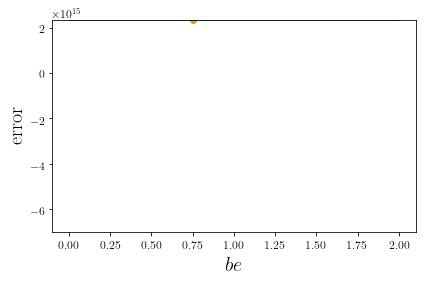

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


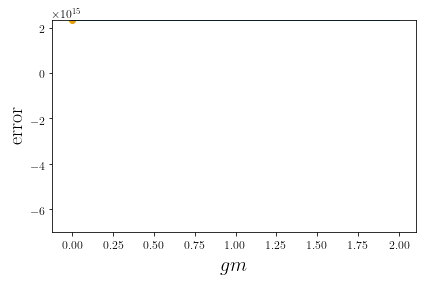

In [210]:
my_model.plot_profiles()